# 第三章

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch03-linreg-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch03-linreg-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [ ]:
%pip install ISLP

我們必須重新啟動執行環境以使用新安裝的版本！

我們在頂層匯入標準函式庫。

In [1]:
# Notebook 使用的匯入（imports）
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
import matplotlib.pyplot as plt  # 繪圖指令與樣式
import seaborn as sns  # 統計視覺化
import statsmodels.api as sm  # 統計模型與推論
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF  # 多重共線性指標
from statsmodels.stats.anova import anova_lm  # ANOVA 檢定
from statsmodels.sandbox.regression.predstd import wls_prediction_std  # WLS 預測區間
from ISLP import load_data  # ISLP 書籍資料集載入
from ISLP.models import (ModelSpec as MS, summarize, poly)  # 模型公式、摘要與多項式工具
from sklearn import linear_model  # 線性模型：LinearRegression/Ridge/Lasso 等
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score  # 評估指標
from sklearn.preprocessing import PolynomialFeatures  # 多項式特徵轉換
from yellowbrick.regressor import PredictionError, ResidualsPlot  # 回歸診斷視覺化

In [2]:
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 匯入套件

### 新的匯入

在本實驗中，我們將介紹新的函式和函式庫。然而，我們會在此處匯入它們，以強調這些是本實驗中的新程式碼物件。將匯入放在 notebook 的頂部使程式碼更具可讀性，因為掃描前幾行就能告訴我們使用了哪些函式庫。

我們將在下方需要時提供函式的相關細節。

除了匯入整個模組外，也可以只從給定的模組中匯入少數項目。這將有助於保持*命名空間*的乾淨。我們將使用 `statsmodels` 套件中的一些特定物件，在此處匯入。

### 檢視物件和命名空間

函式 `dir()` 提供命名空間中物件的清單。

這顯示了 Python 在頂層能找到的所有內容。有些物件如 `__builtins__` 包含對內建函式（如 `print()`）的參考。

每個 Python 物件都有自己的命名空間概念，也可以用 `dir()` 來存取。這將包括物件的屬性以及與其相關的任何方法。例如，我們在陣列的清單中看到 `'sum'`。

In [3]:
A = np.array([3,5,11])
dir(A)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_namespace__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',


這表示物件 `A.sum` 存在。在這種情況下，它是一個可以用來計算陣列 `A` 總和的方法，如輸入 `A.sum?` 所示。

In [4]:
A.sum()

np.int64(19)

## 簡單線性迴歸（Simple Linear Regression）

在本節中，我們將使用來自 `ISLP.models` 的 [`ModelSpec()`](https://islp.readthedocs.io/en/latest/models/spec.html) 轉換來建構模型矩陣（也稱為設計矩陣）。

我們將使用 ISLP 套件中包含的 [`Boston`](https://islp.readthedocs.io/en/latest/datasets/Boston.html) 房屋資料集。`Boston` 資料集記錄了波士頓周圍 $506$ 個社區的 `medv`（房屋中位價值）。我們將建立迴歸模型來預測 `medv`，使用 $13$ 個預測變數，如 `rmvar`（每戶房屋平均房間數）、`age`（1940年前建造的自住單位比例），以及 `lstat`（低社經地位家庭百分比）。我們將使用 `statsmodels` 來完成此任務，這是一個實作數種常用迴歸方法的 Python 套件。

我們在 ISLP 套件中包含了一個簡單的載入函式 [`load_data()`](https://islp.readthedocs.io/en/latest/data.html)：

In [5]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

輸入 `Boston?` 以了解更多關於這些資料的資訊。

我們開始使用 `sm.OLS()` 函式來擬合一個簡單的線性迴歸模型。我們的反應變數將是 `medv`，而 `lstat` 將是單一預測變數。對於這個模型，我們可以手動建立模型矩陣。

In [6]:
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]),
                  'lstat': Boston['lstat']})
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


我們提取反應變數並擬合模型。

In [7]:
y = Boston['medv']
model = sm.OLS(y, X) # Intercept is not included https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
results = model.fit()

注意：`sm.OLS()` 不會擬合模型；它指定模型，然後 `model.fit()` 進行實際擬合。

我們的 ISLP 函式 `summarize()` 產生一個簡單的參數估計表格，包含它們的標準誤、t 統計量和 p 值。該函式接受單一參數，如這裡由 `fit` 方法返回的 `results` 物件，並返回這樣的摘要。

In [8]:
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


在介紹處理已擬合模型的其他方法之前，我們先來介紹一個更有用且通用的建構模型矩陣 `X` 的框架。

### 使用轉換：Fit 和 Transform

我們上面的模型有單一預測變數，建構 `X` 很直接。實際上，我們經常擬合具有多個預測變數的模型，通常從陣列或資料框中選取。在擬合模型前，我們可能希望對變數進行轉換、指定變數間的交互作用，並將某些特定變數展開為變數集合（例如多項式）。`sklearn` 套件對這種類型的任務有特定的概念：*轉換*。轉換是以某些參數作為參數來建立的物件。該物件有兩個主要方法：`fit()` 和 `transform()`。

我們通過 ISLP 函式庫中的轉換 [`ModelSpec()`](https://islp.readthedocs.io/en/latest/models/spec.html) 提供了一個用於指定模型和建構模型矩陣的通用方法。`ModelSpec()`（在匯入中重新命名為 `MS()`）建立一個轉換物件，然後使用 `transform()` 和 `fit()` 方法來建構對應的模型矩陣。

我們首先描述這個過程，用 `Boston` 資料框中的單一預測變數 `lstat` 來建立簡單迴歸模型，但在本實驗和本書的其他實驗中的更複雜任務中會重複使用它。在我們的案例中，轉換是由表達式 `design = MS(['lstat'])` 建立的。

`fit()` 方法接受原始陣列並可能對其進行一些初始計算，如轉換物件中所指定的。例如，它可能計算用於中心化和縮放的平均值和標準差。`transform()` 方法將已擬合的轉換套用到陣列資料，並產生模型矩陣。

In [9]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


在這個簡單的情況下，`fit()` 方法做得很少；它只是檢查 `design` 中指定的變數 `'lstat'` 存在於 `Boston` 中。然後 `transform()` 建構具有兩欄的模型矩陣：一個 `intercept` 和變數 `lstat`。

這兩個操作可以通過 `fit_transform()` 方法合併。

In [10]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


注意，如同上一個程式碼塊中兩個步驟分別進行時一樣，`design` 物件因為 `fit()` 操作而改變。當我們擬合涉及交互作用和轉換的更複雜模型時，這種寫法的方便性將變得更清楚。

讓我們回到已擬合的迴歸模型。這個 `results` 物件有幾個可以用於推論的方法。我們已經展示了用於顯示擬合要點的 `summarize()` 函式。為了獲得擬合的完整且相當詳細的摘要，我們可以使用 `summary()` 方法。

In [11]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           5.08e-88
Time:                        08:00:16   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

已擬合的係數也可以作為 `results` 的 `params` 屬性來檢索。

In [12]:
results.params

,0
intercept,34.553841
lstat,-0.950049


`get_prediction()` 方法可以用於獲得預測，並為給定 `lstat` 值的 `medv` 預測產生信賴區間和預測區間。

我們首先建立一個新的資料框，在這種情況下只包含變數 `lstat`，其中包含我們希望進行預測的該變數的值。然後我們使用 `design` 的 `transform()` 方法來建立對應的模型矩陣。

In [13]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


接下來我們在 `newX` 處計算預測，並透過提取 `predicted_mean` 屬性來查看它們。

In [14]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

我們可以產生預測值的信賴區間。

In [15]:
new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

預測區間通過設定 `obs=True` 來計算：

In [16]:
new_predictions.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

例如，與 `lstat` 值 10 相關的 95% 信賴區間是 (24.47, 25.63)，而 95% 預測區間是 (12.82, 37.28)。如預期的，信賴和預測區間都以相同點為中心（當 `lstat` 等於 10 時，`medv` 的預測值為 25.05），但後者明顯更寬。

接下來，我們將使用 `DataFrame.plot.scatter()` 繪製 `medv` 和 `lstat`，並希望在產生的圖中加入迴歸線。

### 定義函式

雖然在 ISLP 套件中有一個函式可以為現有圖表添加線條，但這邊我們先以純Python內建語法來定義我們的第一個函式來執行此操作。

In [17]:
def abline(ax, b, m):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim)

上面說明了幾個重點。首先，我們看到定義函式的語法：`def funcname(...)`。這個函式有引數 `ax, b, m`，其中 `ax` 是現有繪圖的軸物件，`b` 是截距，`m` 是所需線條的斜率。其他繪圖選項可以透過包含額外的可選引數傳遞給 `ax.plot`，如下所示：

In [18]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)


添加 `*args` 允許任意數量的非命名引數傳入 `abline`，而 `*kwargs` 允許任意數量的命名引數（如 `linewidth=3`）傳入 `abline`。在我們的函式中，我們將這些引數原樣傳遞給上面的 `ax.plot`。有興趣學習更多關於函式的讀者可以參考 [docs.python.org/tutorial](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) 中定義函式的章節。

讓我們使用我們的新函式將這條迴歸線加入到 `medv` vs. `lstat` 的繪圖中。

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/tmp/ipython-input-1591428221.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
/tmp/ipython-input-1591428221.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resul

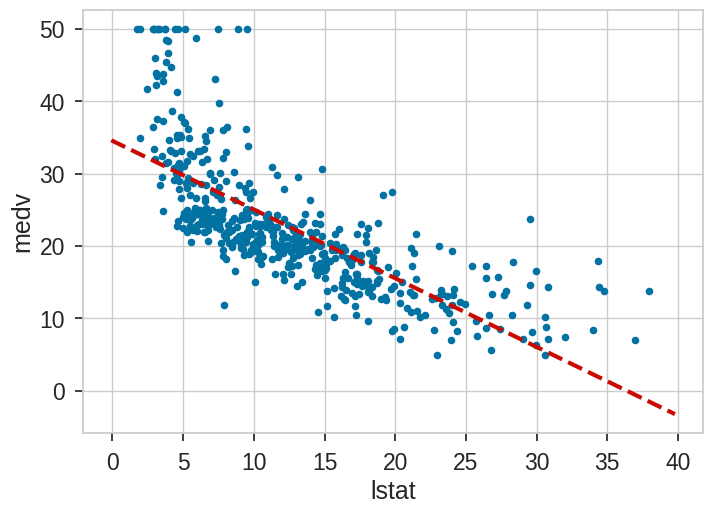

In [19]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax,
       results.params[0],
       results.params[1],
       'r--',
       linewidth=3)


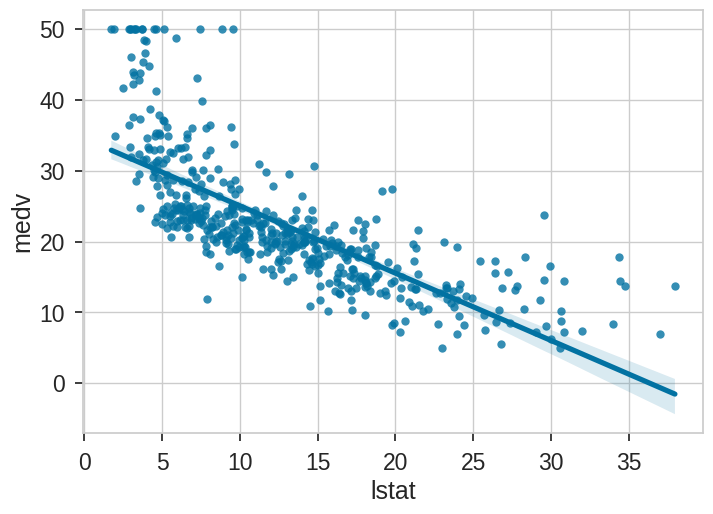

In [20]:
# Another way is using seaborn
sns.regplot(x='lstat',y='medv', data=Boston);

因此，對 `ax.plot()` 的最終呼叫是 `ax.plot(xlim, ylim, 'r--', linewidth=3)`。我們使用引數 `'r--'` 來產生紅色虛線，並添加引數使其寬度為 3。`lstat` 和 `medv` 之間的關係似乎有一些非線性的趨勢。我們將在本實驗後面探討這個問題。

如上所述，有一個函式庫現有函式可以為繪圖添加線條 `ax.axline()`。但知道如何寫這樣功能的函式將能讓我們進行更多可能的客製化功能。

接下來我們來畫一些診斷圖，其中幾個在第 3.3.3 節中討論過。我們可以在 `results` 物件的屬性中找到擬合值和殘差。使用 `get_influence()` method 計算描述迴歸模型的各種影響測度。

> 下面的程式碼由於我們不會使用從 `subplots()` 返回的第一個值 `fig` 組件，因此我們只接收第二個返回值到 `ax` 中。

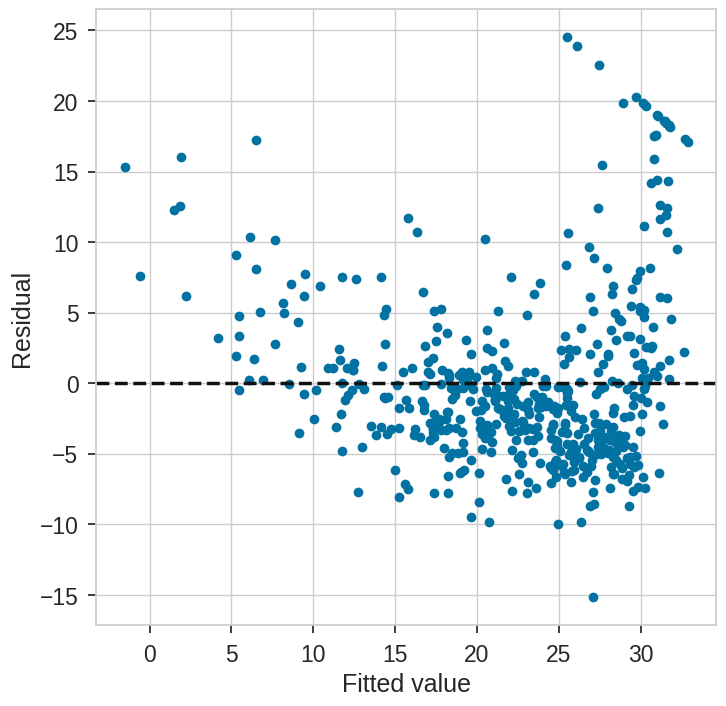

In [21]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

我們使用 `ax.axhline()` method 在 0 處加入參考的水平線，指示它應該是黑色的（`c='k'`）並具有虛線樣式（`ls='--'`）。

根據殘差圖，有一些非線性的趨勢。可以使用 `get_influence()` method 回傳值的 `hat_matrix_diag` 屬性，為任意數量的預測變數計算槓桿統計量。

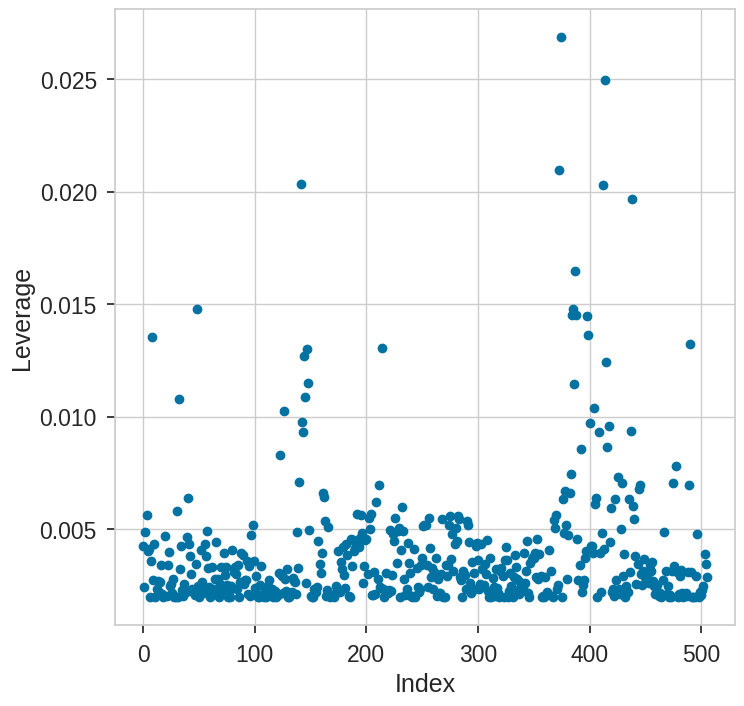

In [22]:
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage');

In [23]:
np.argmax(infl.hat_matrix_diag)

np.int64(374)

`np.argmax()` function 識別陣列中最大元素的索引，可選擇在陣列的軸上計算。在這種情況下，我們可以確定哪個觀察值具有最大的槓桿統計量。

根據 `ols()` 的結果繪製四個診斷圖。以下診斷突圍根據這些參考文件繪製 [https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.OLSInfluence.html) 和 [https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults)。

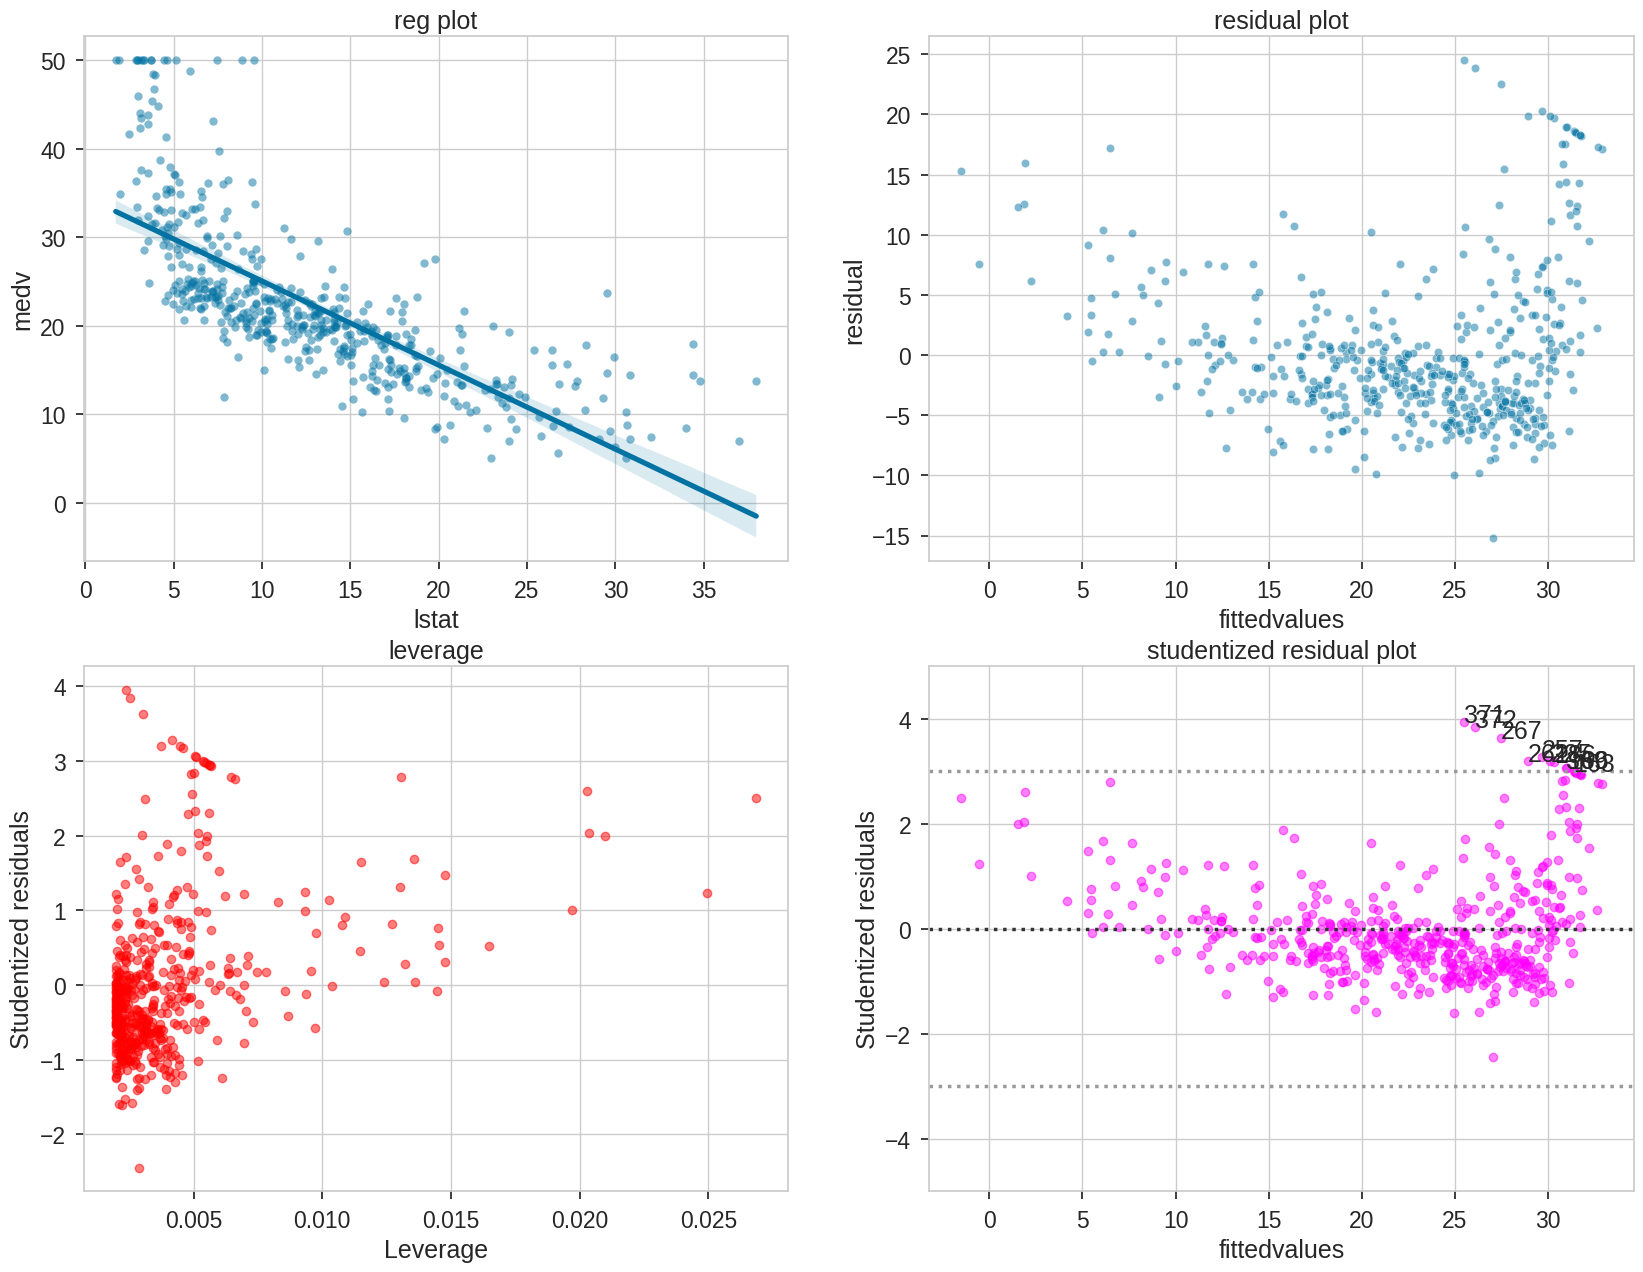

In [24]:
infl = results.get_influence()
ols_sm_resid = results.resid # residuals
ols_fitted = results.fittedvalues
#prstd = wls_預測_std(results)[0]
#ols_sm_resid_stud = ols_sm_resid / prstd # studentized residuals or infl.resid_studentized_internal
ols_sm_resid_stud = infl.resid_studentized_internal
leverage = infl.hat_matrix_diag


f, axes = plt.subplots(2, 2, sharex=False, sharey=False)
f.set_figheight(15)
f.set_figwidth(20)

sns.regplot(x='lstat', y='medv', data=Boston, ax=axes[0, 0], scatter_kws={'alpha': 0.5}) # regression plot
axes[0, 0].set_title("reg plot")
sns.scatterplot(x=ols_fitted,y=ols_sm_resid, ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_xlabel("fittedvalues")
axes[0, 1].set_ylabel("residual")
axes[0, 1].set_title("residual plot")

# custom leverage plot instead of above
axes[1, 0].scatter(leverage, ols_sm_resid_stud, alpha=0.5, color='red')
axes[1, 0].set_xlabel("Leverage")
axes[1, 0].set_ylabel("Studentized residuals")
axes[1, 0].set_title("leverage")

# studentized residual plot
axes[1, 1].scatter(ols_fitted, ols_sm_resid_stud, alpha=0.5, color='magenta')
axes[1, 1].axhline(0, ls=":", c=".2")
axes[1, 1].axhline(-3, ls=":", c=".6")
axes[1, 1].axhline(3, ls=":", c=".6")
axes[1, 1].set_ylim(-5, 5)
axes[1, 1].set_xlabel("fittedvalues")
axes[1, 1].set_ylabel("Studentized residuals")
axes[1, 1].set_title("studentized residual plot")

x = results.fittedvalues[np.logical_or(ols_sm_resid_stud > 3, ols_sm_resid_stud < -3)]
y = ols_sm_resid_stud[np.logical_or(ols_sm_resid_stud > 3, ols_sm_resid_stud < -3)]

for i, x, y in zip(x.index, x, y):
    axes[1, 1].annotate(i, xy=(x, y));

### 補充 - 其他有用的繪圖

`seaborn` 也有殘差圖的功能

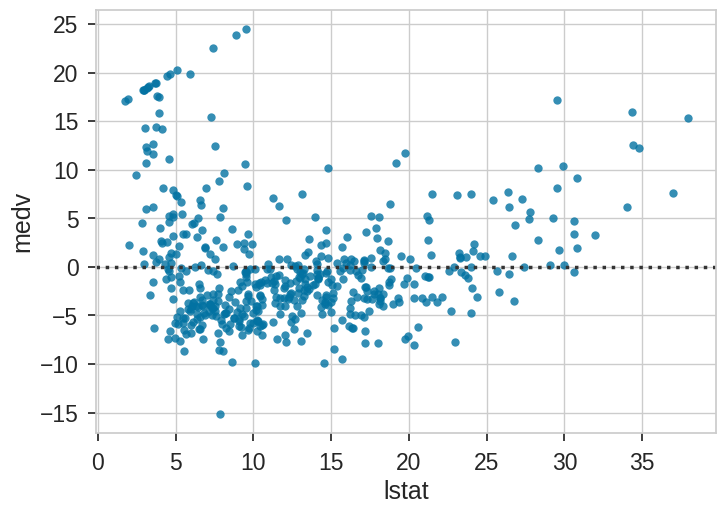

In [25]:
sns.residplot(x="lstat", y="medv", data=Boston);

`Statsmodel` 有更多診斷圖，例如影響圖，其中點的大小與 Cook's distance 相關。[https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html](https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html)。

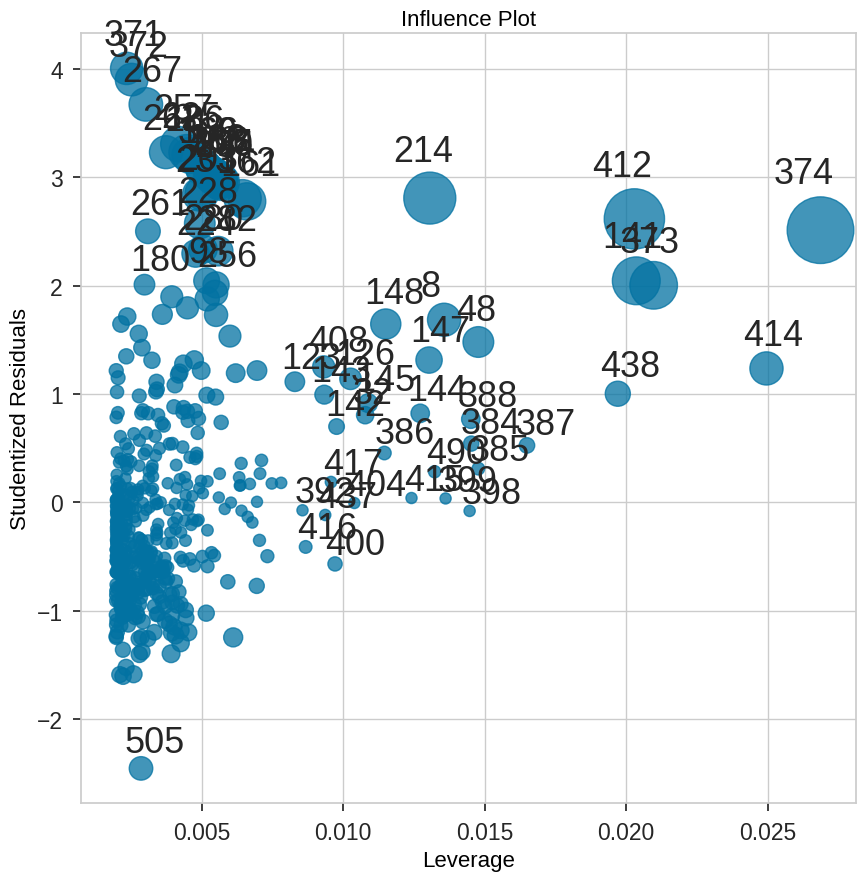

In [26]:
f = sm.graphics.influence_plot(results, criterion="cooks")
f.set_figheight(10)
f.set_figwidth(10)

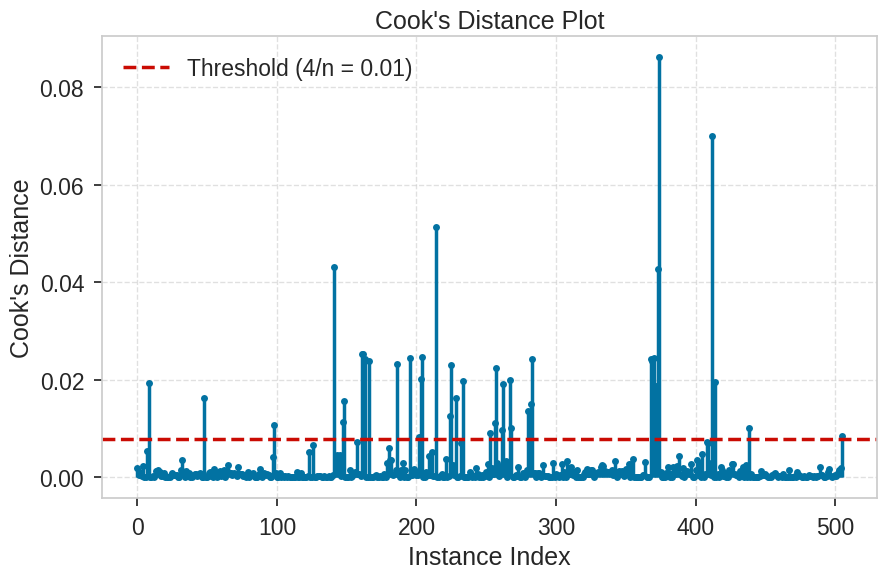

In [28]:
# 1. 獲取影響力分析的結果
influence = results.get_influence()

# 2. 提取 Cook's distance
# influence.cooks_distance 回傳一個 tuple (distance, p-value)
cooks_d = influence.cooks_distance[0]

# 3. 手動繪製 stem plot
plt.figure(figsize=(10, 6))
markerline, stemlines, baseline = plt.stem(
    np.arange(len(cooks_d)),
    cooks_d,
    basefmt=" " # 隱藏基線
)
plt.setp(markerline, 'marker', 'o', 'markersize', 5)
plt.setp(stemlines, 'linestyle', '-')

# 4. 加上一條影響力閾值線，常見的閾值是 4/n
n = len(cooks_d)
threshold = 4 / n
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold (4/n = {threshold:.2f})')

plt.title("Cook's Distance Plot")
plt.xlabel("Instance Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

`plot_regress_exog()` function 是一個便利函式，提供 2x2 繪圖，包含依變數和擬合值與信賴區間對選擇的自變數、模型殘差對選擇的自變數、部分迴歸圖和 CCPR 圖。此函式可用於快速檢查相對於單一回歸變數的建模假設。更多資訊請參考 [https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html#Component-Component-plus-Residual-(CCPR)-Plots](https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html#Component-Component-plus-Residual-(CCPR)-Plots)。

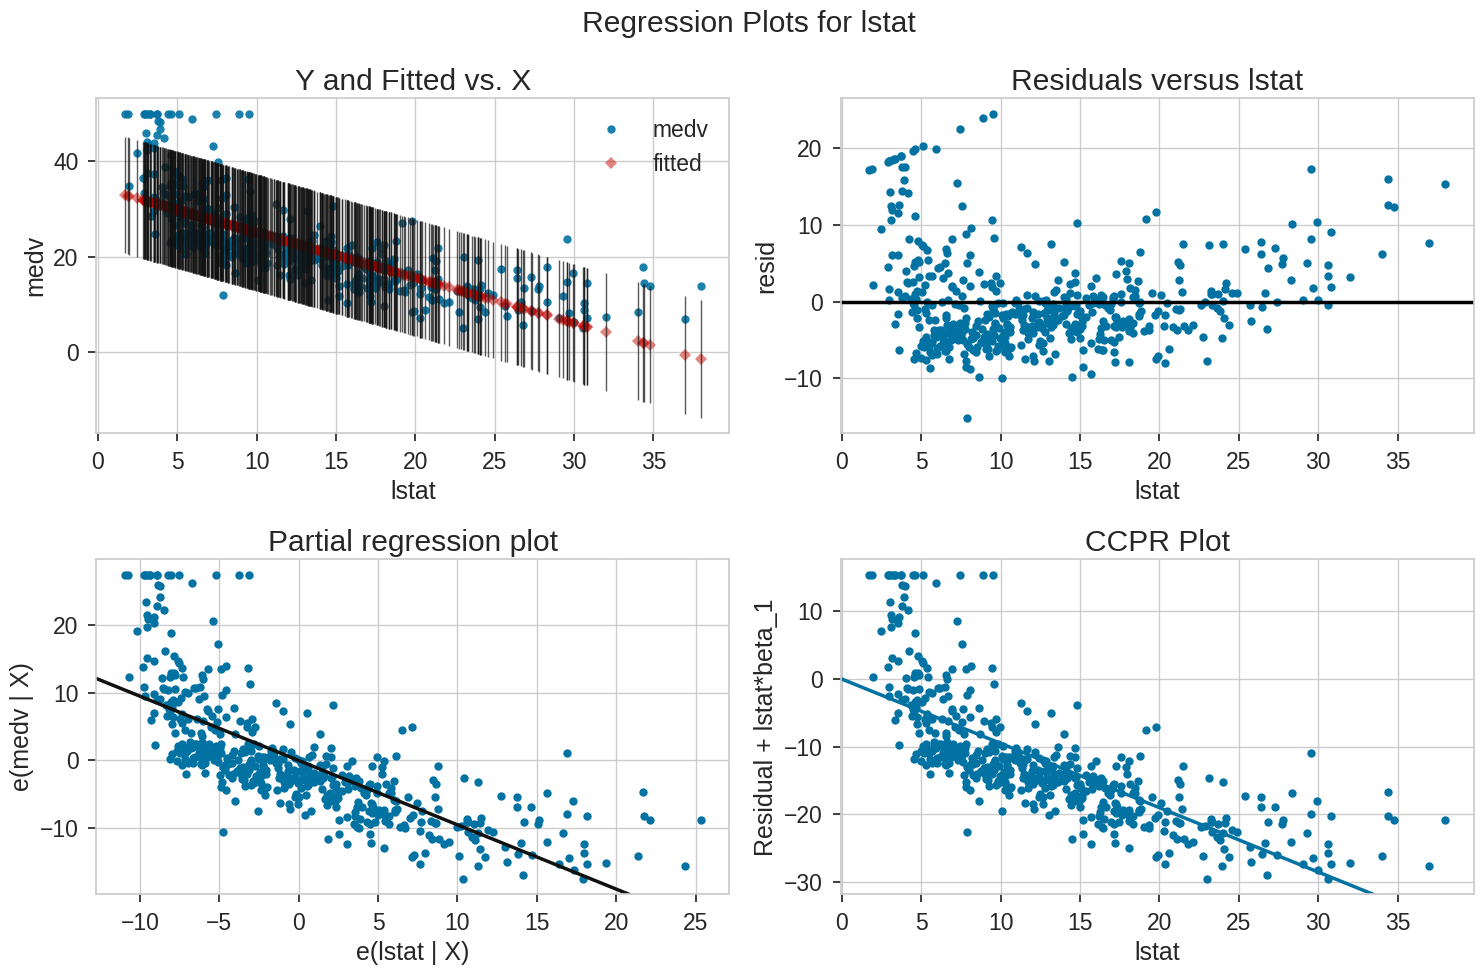

In [29]:
f = sm.graphics.plot_regress_exog(results, "lstat")
f.set_figheight(10)
f.set_figwidth(15)
f.tight_layout(pad=1.0)

## 多元線性迴歸

為了使用最小平方法擬合多元線性迴歸模型，我們再次使用 `ModelSpec()` 轉換來建構所需的模型矩陣和反應變數。我們在這裡考慮擬合兩個變數 `lstat` 和 `age`。

In [30]:
X = MS(['lstat', 'age']).fit_transform(Boston)
y = Boston['medv']
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [31]:
terms = Boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

注意我們如何將第一行壓縮成描述 `X` 構造的簡潔表達式。

`Boston` 資料集包含 12 個變數，因此要以上面的語法輸入所有這些變數來執行使用所有預測變數的迴歸會很麻煩。相反，我們可以使用以下簡寫：

In [32]:
# 我們現在可以使用相同的模型矩陣建構器，使用 `terms` 中的所有變數來擬合模型。
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


如果我們想要使用除了一個變數之外的所有變數進行迴歸，該怎麼辦？例如，在上面的迴歸輸出中，`age` 有很高的 $p$ 值。所以我們可能希望執行排除此預測變數的迴歸。以下語法會導致使用除了 `age` 之外的所有預測變數進行迴歸。

In [33]:
minus_age = Boston.columns.drop(['medv', 'age'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())

,coef,std err,t,P>|t|
intercept,41.5251,4.920,8.441,0.000
crim,-0.1214,0.033,-3.683,0.000
zn,0.0465,0.014,3.379,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8528,0.868,3.287,0.001
nox,-18.4851,3.714,-4.978,0.000
rm,3.6811,0.411,8.951,0.000
dis,-1.5068,0.193,-7.825,0.000
rad,0.2879,0.067,4.322,0.000
tax,-0.0127,0.004,-3.333,0.001


## 多元線性迴歸準確性

我們可以按名稱存取 `results` 的個別組件（`dir(results)` 顯示我們可以使用的內容）。因此，`results.rsquared` 給我們 $R^2$ 值，而 `np.sqrt(results.scale)` 給我們殘差標準誤（RSE）。

In [34]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

In [35]:
results.rsquared

np.float64(0.7343070437613076)

變異數膨脹因子（第 3.3.3 節）有時對評估迴歸模型中模型矩陣的共線性影響很有用。我們將計算多元迴歸擬合中的 VIF，並藉此機會介紹Python中*串列生成式*的概念。

### 串列生成式

我們經常遇到序列物件，希望將其轉換用於其他任務。下面，我們為 `X` 矩陣中的每個特徵計算 VIF，並產生一個索引與 `X` 的欄位一致的資料框。串列推導的概念通常可以使這樣的任務更容易。

串列生成式是在 Python 物件中形成清單的簡單、強大方法。該語言也支援字典、*產生器*生成式，雖然這些超出了我們這裡的範圍。讓我們看一個例子。我們使用函式 `variance_inflation_factor()` 為模型矩陣 `X` 中的每個變數計算 VIF。

In [36]:
vals = [VIF(X, i)
        for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals},
                   index=X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


函式 `VIF()` 接受兩個引數：一個資料框或陣列，和一個變數欄位索引。在上面的程式碼中，我們對 `X` 的所有欄位即時呼叫 `VIF()`。我們上面排除了欄位 0（截距），因為我們對它不感興趣。

上面的物件 `vals` 也可以用以下 for 迴圈構造：

In [37]:
vals = []
for i in range(1, X.values.shape[1]):
    vals.append(VIF(X.values, i))

但串列生成式允許我們以更直接的方式執行這種重複操作。

## 交互作用項

使用 `ModelSpec()` 在線性模型中包含交互作用項很容易。包含元組 `("lstat","age")` 告訴模型矩陣建構器包含 `lstat` 和 `age` 之間的交互作用項。

In [38]:
X = MS(['lstat', 'age',('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


## 預測變數的非線性轉換

模型矩陣建構器可以包含除了欄位名稱、交互作用之外的項目。例如，ISLP 中提供的 [`poly()`](https://islp.readthedocs.io/en/latest/transforms/poly.html) function 指定將表示其第一個引數的多項式函式的欄位添加到模型矩陣中。

In [39]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


與二次項相關的實際上為零的 *p* 值（即上面的第三列）表明它導致了改進的模型。

預設情況下，`poly()` 建立一個包含在模型矩陣中的基礎矩陣，其欄位是*正交多項式*，這是為穩定最小平方計算設計的。{實際上，`poly()` 是獨立函式 `Poly()` 的包裝器，後者在建構模型矩陣中做實際工作。} 或者，如果我們在上面對 `poly()` 的呼叫中包含引數 `raw=True`，基礎矩陣將簡單地由 `lstat` 和 `lstat**2` 組成。由於這些基礎中的任何一個都表示二次多項式，在這種情況下擬合值不會改變，只是多項式係數。另外，預設情況下，由 `poly()` 建立的欄位不包括截距欄位，因為這是由 `MS()` 自動添加的。

我們使用 `anova_lm()` function 進一步量化二次擬合優於線性擬合的程度。請參見 [https://islp.readthedocs.io/en/latest/models/anova.html](https://islp.readthedocs.io/en/latest/models/anova.html)。

In [40]:
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


這裡 `results1` 表示包含預測變數 `lstat` 和 `age` 的線性子模型，而 `results3` 對應於上面帶有 `lstat` 中二次項的更大模型。`anova_lm()` function 執行比較兩個模型的假設檢定。虛無假設是更大模型中的二次項不需要，對立假設是更大模型更優。這裡 *F* 統計量是 177.28，相關的 *p* 值是零。在這種情況下，*F* 統計量是 `results3` 線性模型摘要中二次項的 *t* 統計量的平方——這是這些巢狀模型相差一個自由度的結果。這提供了非常明確的證據，表明 `lstat` 中的二次多項式改進了線性模型。這並不令人驚訝，因為之前我們看到了 `medv` 和 `lstat` 之間關係的非線性證據。

`anova_lm()` function 可以接受超過兩個巢狀模型作為輸入，在這種情況下，它會比較每個連續的模型對。這也解釋了為什麼上面第一列中有 `NaN`，因為沒有先前的模型來比較第一個。

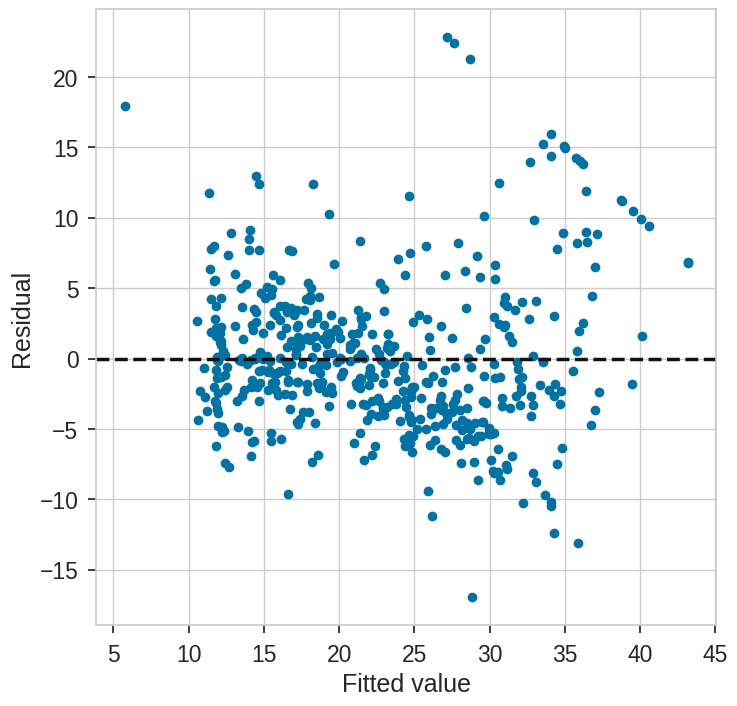

In [41]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results3.fittedvalues, results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

我們看到當二次項包含在模型中時，殘差中幾乎沒有可辨別的模式。為了建立三次或更高次的多項式擬合，我們可以簡單地改變 `poly()` 的 degree 引數。

## 類別預測變數
這裡我們使用 ISLP 套件中包含的 [`Carseats`](https://islp.readthedocs.io/en/latest/datasets/Carseats.html) 資料。我們將嘗試基於多個預測變數來預測 400 個位置的 `Sales`（兒童汽車安全座椅銷售量）。

In [42]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

`Carseats` 資料包括類別預測變數，如 `ShelveLoc`，這是貨架位置品質的指標——即店內展示汽車安全座椅的空間。預測變數 `ShelveLoc` 取三個可能值：`Bad`、`Medium` 和 `Good`。給定像 `ShelveLoc` 這樣的類別變數，`ModelSpec()` 自動產生虛擬變數。這些變數經常被稱為分類特徵的*獨熱編碼*。它們的欄位加起來為一，所以為了避免與截距的共線性，第一欄被去掉。下面我們看到欄位 `ShelveLoc[Bad]` 已被去掉，因為 `Bad` 是 `ShelveLoc` 的第一個水準。下面我們擬合包含一些交互作用項的多元迴歸模型。

In [43]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
                   ('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


在上面的第一行中，我們將 `allvars` 設為清單，這樣我們可以在下面兩行加入交互作用項。我們的模型矩陣建構器建立了一個 `ShelveLoc[Good]` 虛擬變數，如果貨架位置好則取值 1，否則為 0。它也建立了一個 `ShelveLoc[Medium]` 虛擬變數，如果貨架位置中等則為 1，否則為 0。壞的貨架位置對應這兩個虛擬變數都為零。迴歸輸出中 `ShelveLoc[Good]` 係數為正表示好的貨架位置與高銷售量相關（相對於壞位置）。`ShelveLoc[Medium]` 有較小的正係數，表示中等貨架位置導致比壞貨架位置更高的銷售量，但比好貨架位置的銷售量低。

更多資訊可參考 `pd.get_dummies()` ([https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)) 以及 `pd.cut()` ([https://pandas.pydata.org/docs/reference/api/pandas.cut.html](https://pandas.pydata.org/docs/reference/api/pandas.cut.html))。


## sklearn 是在 Python 中執行 OLS 的另一個常見方式

查看 `sklearn`（[https://scikit-learn.org/stable/modules/linear_model.html](https://scikit-learn.org/stable/modules/linear_model.html)）

In [44]:
# ols model with intercept
ols_sl = linear_model.LinearRegression(fit_intercept=True)

# fitted ols model (.values.reshape(-1, 1) is required for single predictor?)
x_train = Boston.lstat.values.reshape(-1, 1)
y_true =  Boston.medv
ols_sl.fit(x_train, y_true)

y_pred = ols_sl.predict(x_train)
# summary
ols_sl.intercept_, ols_sl.coef_

(np.float64(34.5538408793831), array([-0.95004935]))

In [45]:
residual = y_true - y_pred

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


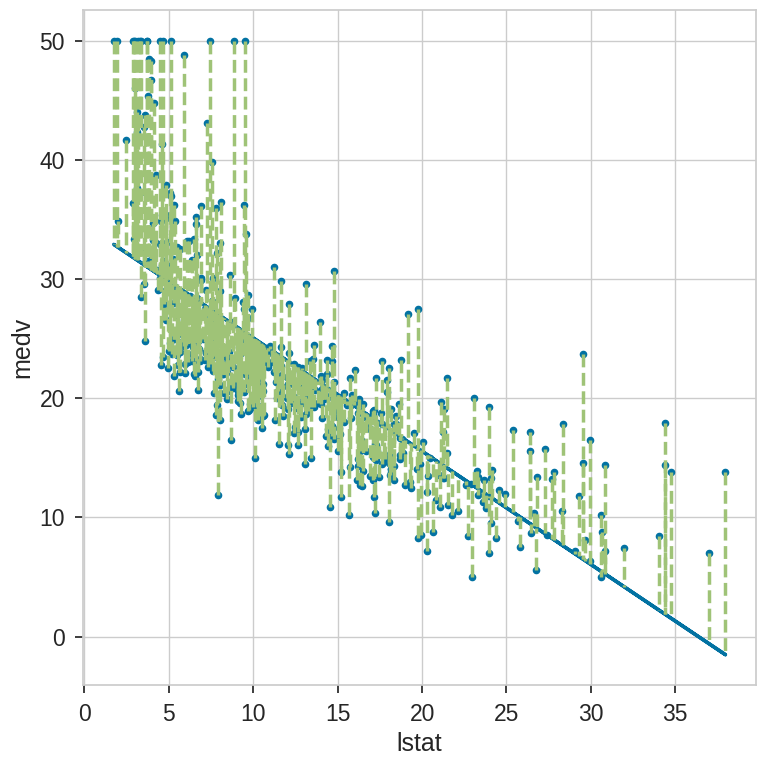

In [46]:
ax = Boston.plot.scatter(x='lstat', y='medv', figsize=(8, 8))
ax.plot(Boston.lstat, y_pred)
for x, yactual, yfitted in zip(Boston.lstat, Boston.medv, y_pred):
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

In [47]:
ols_sl_summary = {'R2': r2_score(y_true, y_pred),
                  'Ex. Var': explained_variance_score(y_true, y_pred),
                  'MSE': mean_squared_error(y_true, y_pred)}

for k, v in ols_sl_summary.items():
    print(k, ':', v)

R2 : 0.5441462975864797
Ex. Var : 0.5441462975864798
MSE : 38.48296722989415


In [48]:
# out-of-sample 預測s
ols_sl.predict(np.array([5, 10, 15]).reshape(-1, 1))

array([29.80359411, 25.05334734, 20.30310057])

### 補充 - sklearn 的視覺化工具

`sklearn` 沒有內建像 seaborn 這樣的統計視覺化工具，但我們可以使用 `yellowbrick`（[https://www.scikit-yb.org/en/latest/](https://www.scikit-yb.org/en/latest/)）

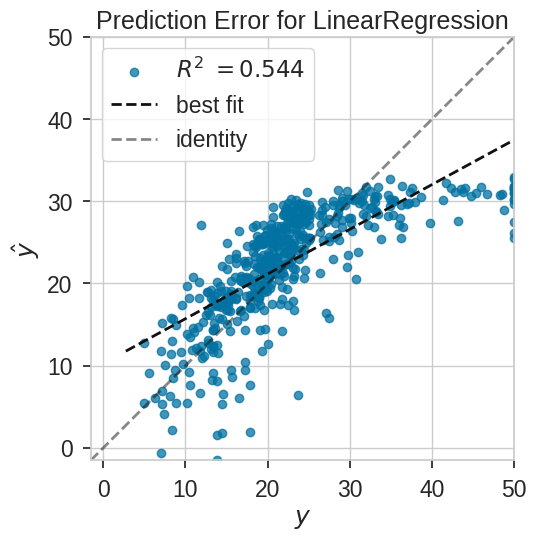

In [49]:
model = linear_model.LinearRegression(fit_intercept=True)
visualizer = PredictionError(model)
visualizer.fit(x_train, y_true)  # Fit the training data to the visualizer
visualizer.score(x_train, y_true)
visualizer.show();

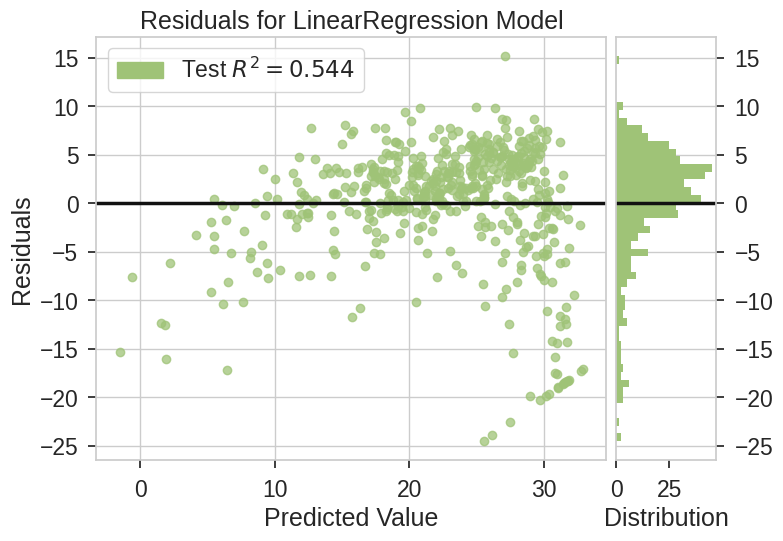

In [50]:
visualizer = ResidualsPlot(model, is_fitted=True)
visualizer.score(x_train, y_true)  # Evaluate the model on the test data
visualizer.show();

直方圖可以被 Q-Q 圖取代，這是檢查殘差是否呈常態分布的常用方法。如果殘差呈常態分布，那麼它們的分位數與常態分布的分位數相對繪製時應該形成一條直線。

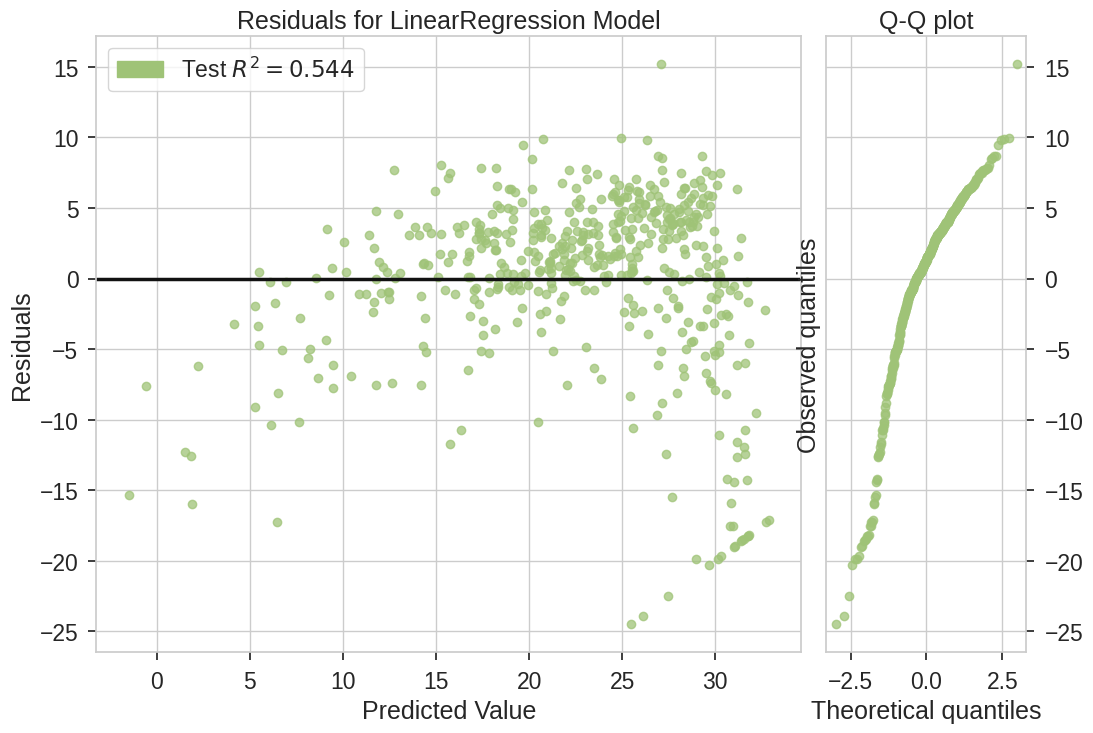

In [51]:
plt.figure(figsize=(12,8))
visualizer = ResidualsPlot(model, hist=False, qqplot=True, is_fitted=True)
visualizer.score(x_train, y_true)  # Evaluate the model on the test data
visualizer.show();